In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from data_load_preprocess import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from viz import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import viz_weights

# load results from a directory

In [5]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_sgd'
print(os.listdir(out_dir_main))
folder = 'mnist_short'

['cifar10_short', 'mnist_long', 'mnist_short', 'cifar10_long']


In [6]:
# depending on how much is saved, this may take a while
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
# results.describe()
# results.head()

# plot basic things for entire dataframe

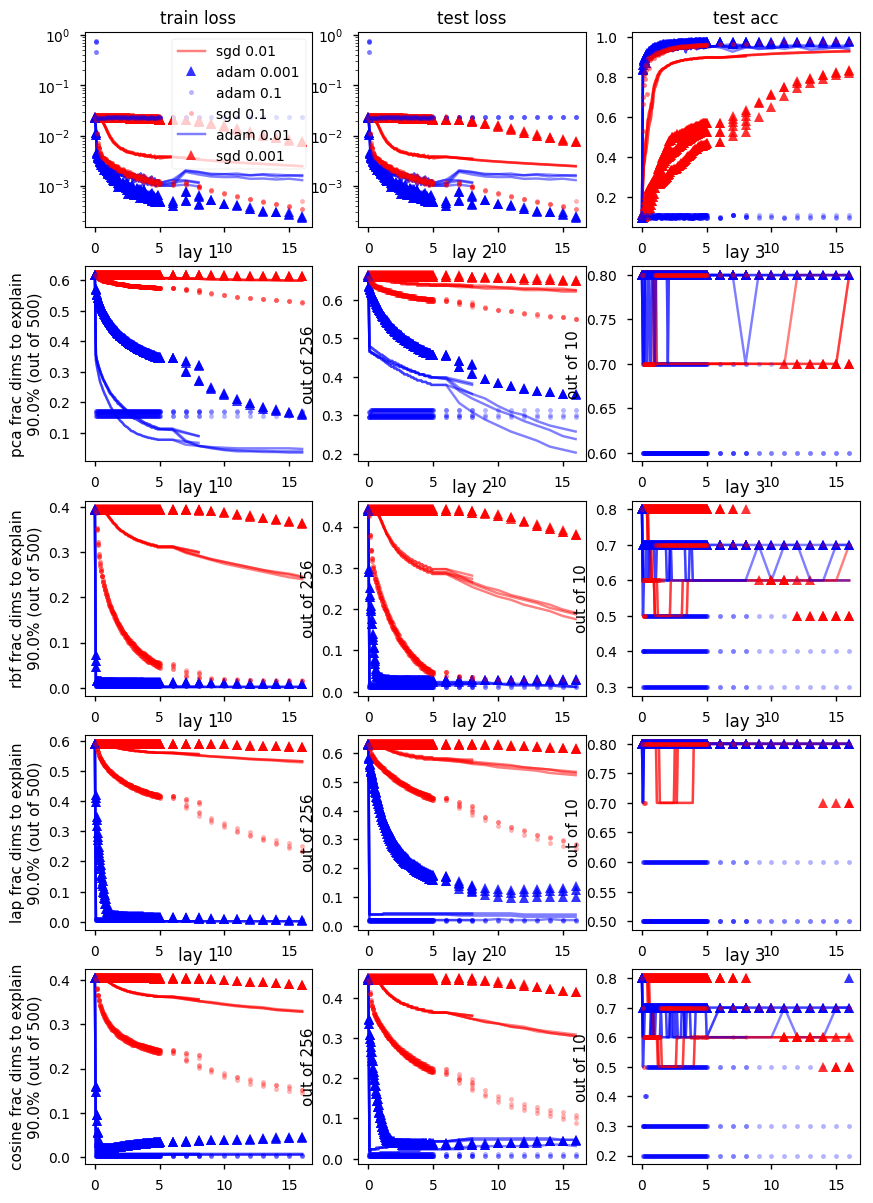

In [8]:
viz_weights.plot_dims(results)

# look at the lay 1 weights

just plot them all (this takes ~2 mins)

In [ ]:
# plot all the weights
def plot_weights(W, dset='mnist'): # W is num_filters x im_size
    num_filters = W.shape[0]
    if dset == 'mnist' or dset is np.nan:
        filts = W.reshape((num_filters, 28, 28))
    elif dset =='cifar10':
        W = (W - np.min(W)) / (np.max(W) - np.min(W))
        filts = W.reshape((num_filters, 3, 32, 32))
        filts = filts.transpose((0, 2, 3, 1))

    R = math.floor(np.sqrt(num_filters))
    C = math.ceil(num_filters / R)
    ratio = 1.0 * R/C
    plt.figure(figsize=(6, 6*R/C))
    for i in range(num_filters):
        plt.subplot(R, C, i+1)
        plt.imshow(filts[i], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
# optimizer = 'adam'
# lr = 0.1
for optimizer in ['sgd', 'adam']:
    for lr in [0.1, 0.01, 0.001]:
        runs = results[results.lr==lr]
        runs = runs[runs.optimizer==optimizer]
        run = runs.iloc[0]
        weight_dict = run.weights
        min_key, max_key = min(weight_dict.keys()), max(weight_dict.keys())
        #     print('init', optimizer, 'lr=' + str(lr))
        #     w = ws[min_key]['fc1.weight']
        #     plot_weights(w)

        print('final', optimizer, 'lr=' + str(lr))
        w = weight_dict[max_key]['fc1.weight']
        plot_weights(w, run.dset)
        plt.savefig('figs/' + optimizer + '_' + 'lr=' + str(lr) + '.pdf', dpi=300)
        # plt.show()

# visualize pcs

In [ ]:
# pca
optimizer, lr = 'adam', 0.01

# get w
runs = results[results.lr==lr]
runs = runs[runs.optimizer==optimizer]
run = runs.iloc[0]
weight_dict = run.weights
w = weight_dict[max(weight_dict.keys())]['fc1.weight']

# look at pcs
pca = PCA(n_components=w.shape[1])
pca.fit(w)
cum = deepcopy(pca.explained_variance_ratio_)
for i in range(1, len(cum)):
    cum[i] += cum[i-1]
plt.plot(cum, 'o')
plt.ylabel('cumulative explained var')
plt.xlabel('num pcs')
plt.show()

print('first pcs..')
plot_weights(pca.components_[:200], run.dset)
plt.show()

# norm distrs

In [ ]:
# pca
plt.figure(figsize=(9, 5))
R, C = 2, 3
for j, optimizer in enumerate(['sgd', 'adam']):
    for lr in [0.1, 0.01, 0.001]:
        if not (optimizer == 'adam' and lr == 0.1):
            # get ws
            runs = results[results.lr==lr]
            runs = runs[runs.optimizer==optimizer]
            run = runs.iloc[0]
            weight_dict_list = run.weights
            weight_dict = weight_dict_list[max(weight_dict_list.keys())]
            ws = [weight_dict['fc1.weight'], weight_dict['fc2.weight'], weight_dict['fc3.weight']]
            w_norms = [np.sum(np.abs(w)**2, axis=1)**(1./2) for w in ws]
    #         w_norms = [np.sum(np.abs(w)**1, axis=1)**(1./1) for w in ws]        

            plt.subplot(R, C, 1 + j * C)
            plt.hist(w_norms[0], label=str(lr))
            if j == 0:
                plt.title('lay1 norms')
            plt.ylabel(optimizer)

            plt.subplot(R, C, 2 + j * C)    
            plt.hist(w_norms[1], label=str(lr))
            if j == 0:
                plt.title('lay2 norms')    

            plt.subplot(R, C, 3 + j * C)    
            plt.hist(w_norms[2], label=str(lr))
            if j == 0:
                plt.title('lay3 norms')              
plt.legend()
plt.show()